## 2 Layer MLP
- With hidden layer of size 64 and dropout with 0.5 probability
- Softmax at last classification layer 
- Learning rate of 0.001
- Over 50-100 epochs

In [17]:
import numpy as np
import tensorflow as tf
import argparse
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import math
# import wandb
# from wandb.integration.keras.callbacks import WandbMetricsLogger, WandbModelCheckpoint


encoder = load_model("../Models/Decoder/encoder_classifier.keras")
X = np.load("../Data/LPS/sal-lps-150-1500(labeled)_data.npy")
Y = np.load("../Data/LPS/sal-lps-150-1500(labeled)_labels.npy")
# X = np.load("../Data/LPS/sal-lps-150-1500(labeled)_fulltest_data.npy")
# Y = np.load("../Data/LPS/sal-lps-150-1500(labeled)_fulltest_labels.npy")
print(X.shape)


(3274, 67499)


In [18]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0015,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True
)

In [3]:
# wandb.init(

#     project="Classifier Tuning",

#     # track hyperparameters and run metadata with wandb.config
#     config={
#         "hidden_size": 64,
#         "activation_1": "tanh",
#         "dropout": 0.5,
#         "output_size": 2,
#         "output_activation": "softmax",
#         "optimizer": "adam",
#         "learning_rate": lr_schedule,
#         "loss": "sparse_categorical_crossentropy",
#         "metric": "accuracy",
#         "epochs": 50,
#         "batch_size": 32
#     }
# )

# config = wandb.config

In [19]:
class MLPClassifier(tf.keras.Model):
    def __init__(self, encoder, num_classes=2, hidden_size=64, dropout_rate=0.5, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        # freeze encoder if requested
        self.encoder.trainable = not freeze_encoder
        self.hidden = layers.Dense(hidden_size, activation='tanh')
        self.dropout = layers.Dropout(dropout_rate)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=True):
        x = self.encoder(inputs, training=training)   # pass through encoder
        x = self.hidden(x)
        x = self.dropout(x, training=training)
        return self.classifier(x)

In [20]:
# Split into train (60%), temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
# Split temp into val (50% of temp = 20% total) and test (50% of temp = 20% total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42, stratify=y_temp)
del X, X_temp, y_temp

In [21]:
print(f'Training data shape: {X_train.shape}')
print(f'Val data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')


Training data shape: (2291, 67499)
Val data shape: (324, 67499)
Test data shape: (659, 67499)


In [22]:
model = MLPClassifier(encoder, hidden_size=64, dropout_rate=0.5, freeze_encoder=True)

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=4,
    restore_best_weights=True
)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
            )

print("Training started....")
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,    
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[early_stopping,
            #    WandbMetricsLogger(),
            #    WandbModelCheckpoint("models.keras",save_best_only=True,monitor='accuracy')
               ]
)
# wandb.finish()
print("Training completed!")


Training started....
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.6866 - loss: 0.5928 - val_accuracy: 0.8148 - val_loss: 0.4787
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7826 - loss: 0.4735 - val_accuracy: 0.8457 - val_loss: 0.4005
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8141 - loss: 0.4334 - val_accuracy: 0.8735 - val_loss: 0.3673
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8429 - loss: 0.4007 - val_accuracy: 0.8704 - val_loss: 0.3526
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8424 - loss: 0.3801 - val_accuracy: 0.8951 - val_loss: 0.3143
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8372 - loss: 0.3882 - val_accuracy: 0.8981 - val_loss: 0.3063
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8490 - loss: 0.3687 - val_accuracy: 0.8796 - val_loss: 0.3075
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8446 - loss: 0.3649 - val

In [23]:
model.summary()

Model: "mlp_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 250)            │   137,251,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,299,833 (523.76 MB)

 Trainable params: 16,194 (63.26 KB)

 Non-trainable params: 137,251,250 (523.57 MB)

 Optimizer params: 32,389 (126.52 KB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9029 - loss: 0.2815
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
TN: 306, FP: 23, FN: 41, TP: 289
AUC: 0.9656719167357465


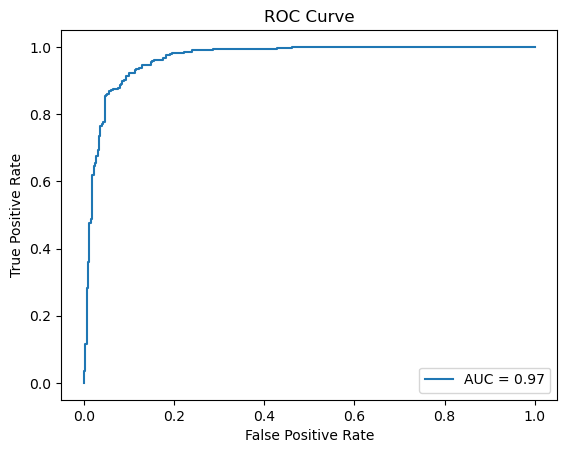

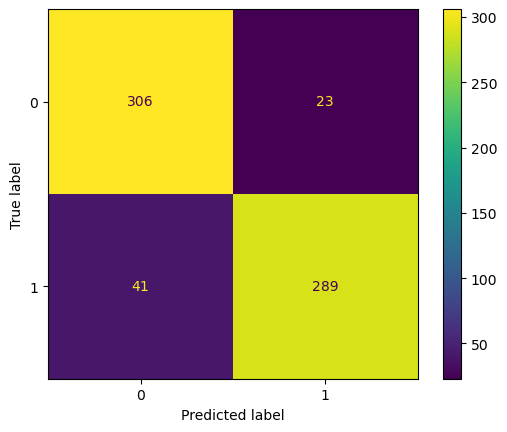

Test loss: 0.2815464735031128
Test Accuracy 0.9028831720352173
Precision: 0.9263
Recall (Sensitivity/TPR): 0.8758
Specificity (TNR): 0.9301
F1-Score: 0.9003
False Positive Rate (FPR): 0.0699
False Negative Rate (FNR): 0.1242
Negative Predictive Value (NPV): 0.8818


In [24]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,precision_score,recall_score,f1_score

loss, accuracy = model.evaluate(X_test, y_test)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

if len(np.unique(y_test)) == 2:
    auc = roc_auc_score(y_test, y_pred_probs[:, 1])
    print(f'AUC: {auc}')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f'Test loss: {loss}')
print(f'Test Accuracy {accuracy}')
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
true_positive_rate = tp / (tp + fn)  # Same as recall/sensitivity
negative_predictive_value = tn / (tn + fn)

print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity/TPR): {recall:.4f}')
print(f'Specificity (TNR): {specificity:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'False Positive Rate (FPR): {false_positive_rate:.4f}')
print(f'False Negative Rate (FNR): {false_negative_rate:.4f}')
print(f'Negative Predictive Value (NPV): {negative_predictive_value:.4f}')

In [25]:
model.encoder.save("../Models/Decoder/encoder_classifier.keras")